In [1]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

import matplotlib.pyplot as plt

In [2]:
submission_files = [
    "/opt/ml/level2_objectdetection-cv-01/Ensemble/bh.csv",
    "/opt/ml/level2_objectdetection-cv-01/Ensemble/dk.csv",
    "/opt/ml/level2_objectdetection-cv-01/Ensemble/hj.csv",
    "/opt/ml/level2_objectdetection-cv-01/Ensemble/hm.csv",
    "/opt/ml/level2_objectdetection-cv-01/Ensemble/tg.csv",
    ]
submission_df = [pd.read_csv(file) for file in submission_files]

In [3]:
submission_df

[                                       PredictionString       image_id
 0     0 0.15859686 215.6635 693.1967 251.71777 731.4...  test/0000.jpg
 1     0 0.5172528 637.24585 648.0722 688.6669 856.75...  test/0001.jpg
 2     0 0.7240297 160.85472 303.59842 241.44107 582....  test/0002.jpg
 3     0 0.15256412 31.343819 305.64227 1000.68506 99...  test/0003.jpg
 4     0 0.3406067 191.19272 244.83427 871.38885 776....  test/0004.jpg
 ...                                                 ...            ...
 4866  0 0.68278253 291.66806 351.063 666.4856 687.87...  test/4866.jpg
 4867  0 0.28269994 628.20087 668.39264 777.04565 719...  test/4867.jpg
 4868  0 0.15880945 546.6488 542.13586 691.28534 782....  test/4868.jpg
 4869  0 0.41929445 3.7654521 216.45134 1013.98334 93...  test/4869.jpg
 4870  0 0.20225331 634.1273 1.7454937 697.5132 541.8...  test/4870.jpg
 
 [4871 rows x 2 columns],
       Unnamed: 0                                   PredictionString  \
 0              0  7 0.9990944862365

In [4]:
annotation = '../dataset/test.json'
coco = COCO(annotation)
image_ids = submission_df[0]['image_id'].tolist()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
prediction_strings = []
file_names = []
iou_thr = 0.7
skip_box_thr = 0.2
weights = [1, 1.5, 1.5, 1.5, 1.5]

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()

        if predict_list == ['nan']:
            predict_list = []
            boxes_list.append([])
            scores_list.append([])
            labels_list.append([])
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
        
    if len(boxes_list):
        # boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr) 
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')


In [6]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./Ensemble/submission_ensemble.csv', index=False)

submission.head()
len(submission)

4871

```python
category = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

fig, axes = plt.subplots(1, 2, figsize=(25, 10))

confidences = [{i:[] for i in range(10)}, {i:[] for i in range(10)}]

for n, df in enumerate(submission_df):
    for lst in df["PredictionString"].tolist():
        predict = str(lst).split()
        for i in range(len(predict)//6):
            label, confidence = int(predict[6*i + 0]), float(predict[6*i + 1])
            confidences[n][label].append(confidence)

tmp1 = [v if v else 0 for _, v in confidences[0].items()]
tmp2 = [v if v else 0 for _, v in confidences[1].items()]

axes[0].boxplot(tmp1)
axes[1].boxplot(tmp2)
axes[0].set_xticks(range(1, len(category)+1))
axes[1].set_xticks(range(1, len(category)+1))
axes[0].set_xticklabels(category)
axes[1].set_xticklabels(category)
plt.show()
```

In [7]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

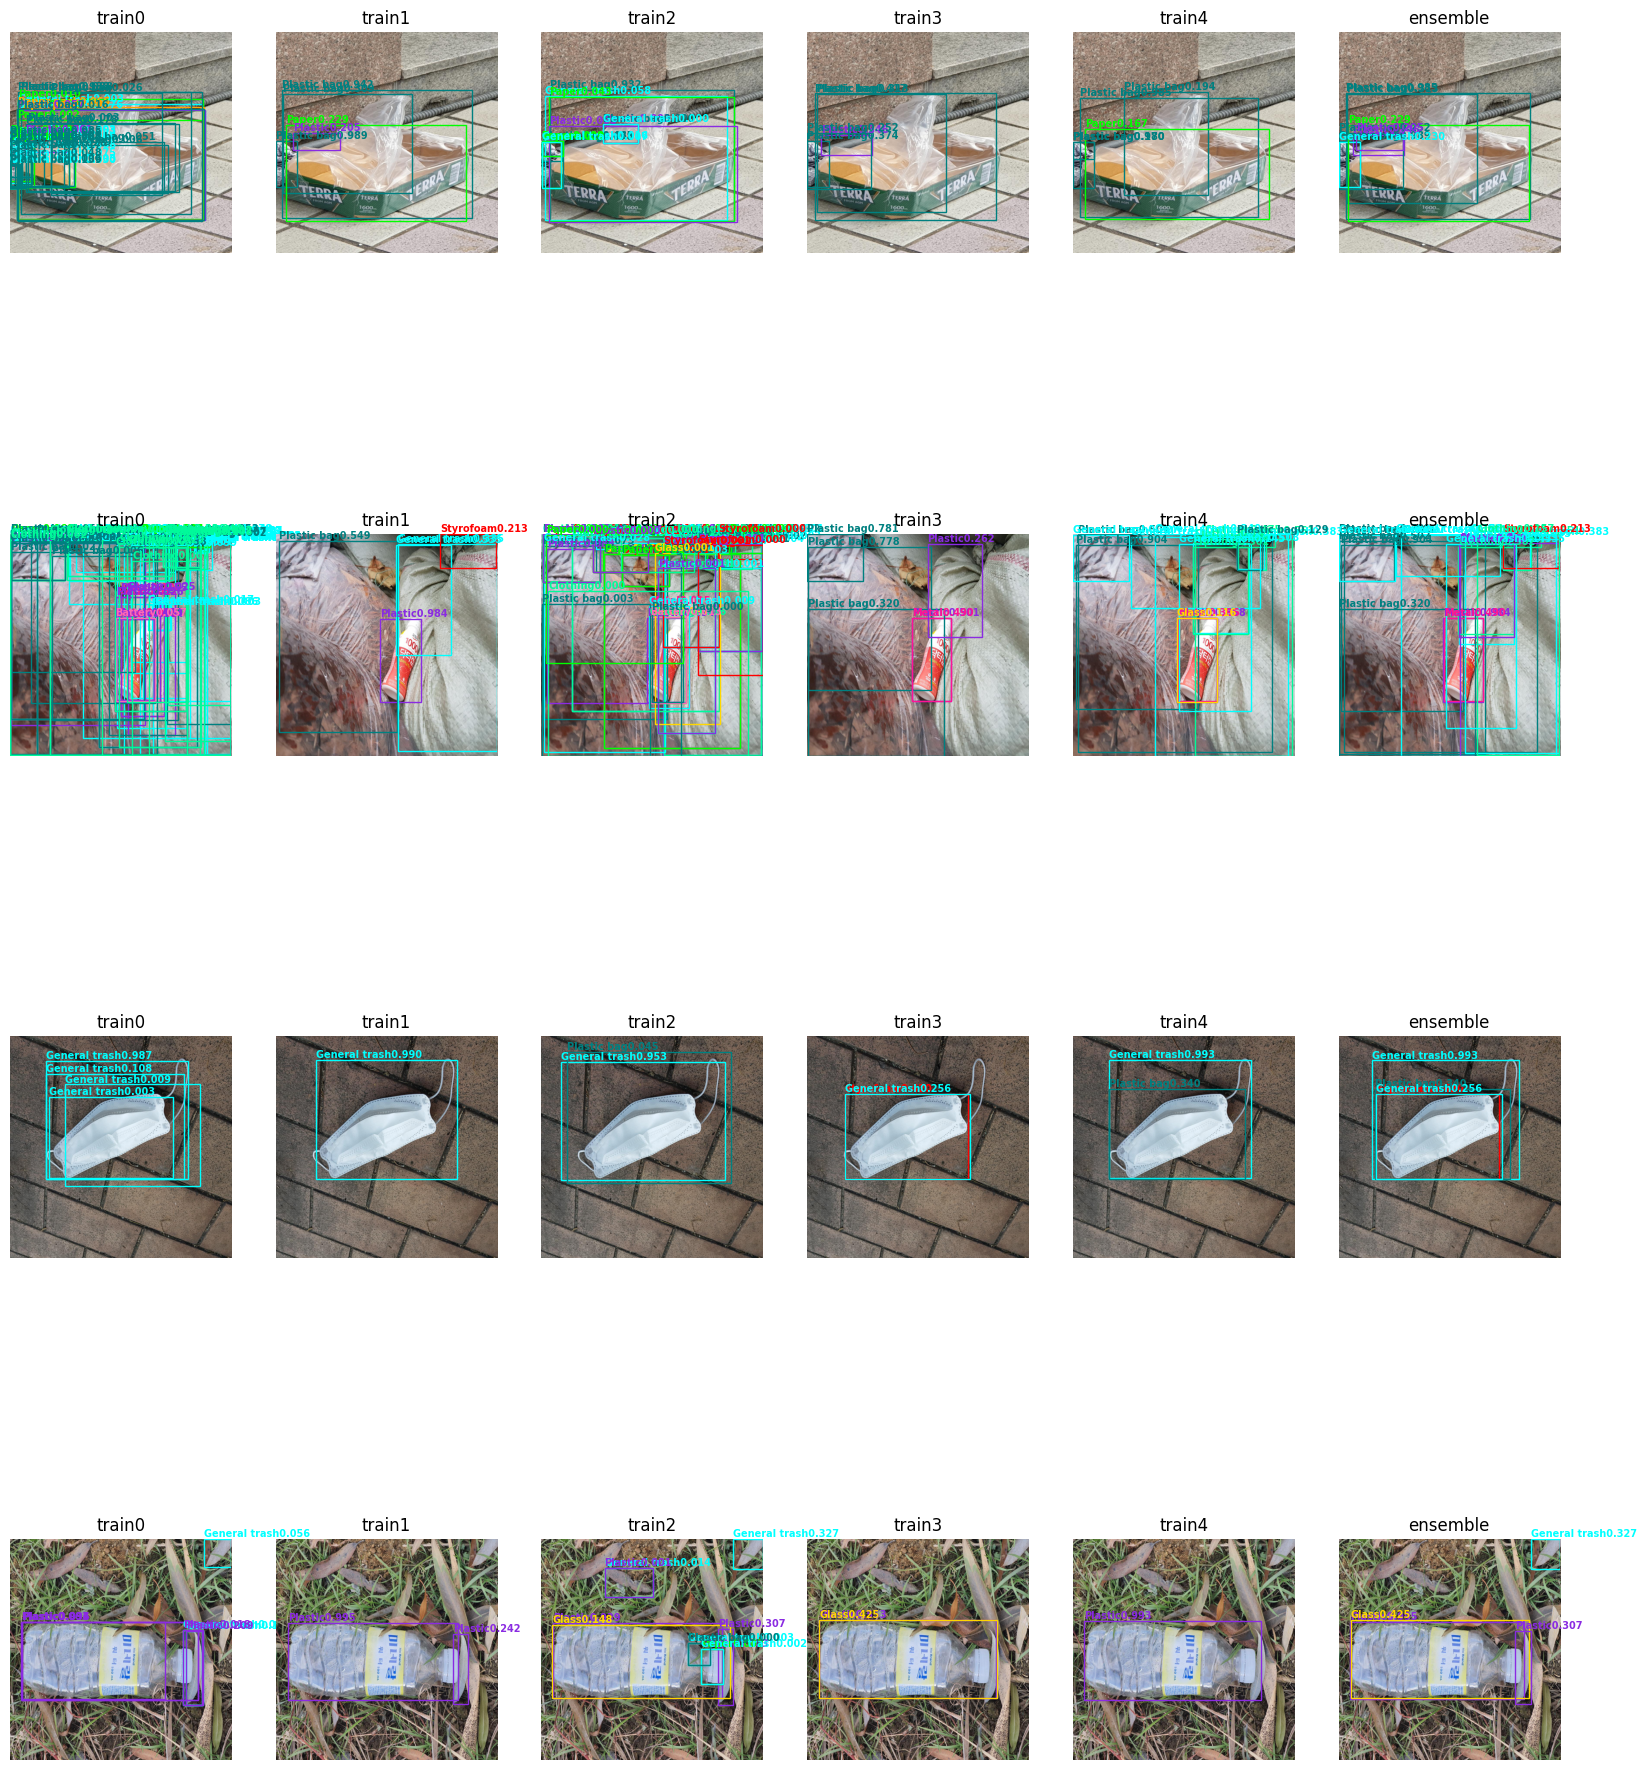

In [8]:
colors = ['cyan', 'lime', 'orange', 'deeppink', 'gold', 'blueviolet', 'red', 'teal', 'hotpink', 'mediumspringgreen']
category = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

size = len(submission_files) + 1

fig, axes = plt.subplots(4, size, figsize=(20, 25))

informations = {f"train{idx}" : df for idx, df in enumerate(submission_df)}
informations['ensemble'] = submission
for y, image_id in enumerate(image_ids[140:144]):
    img_path = os.path.join("../dataset/", image_id)
                            
    for i, (name, df) in enumerate(informations.items()):
        predict_list = str(df[df['image_id'] == image_id]['PredictionString'].tolist()[0]).split()
        x = i % size
        img = Image.open(img_path)

        axes[y][x].imshow(img)
        axes[y][x].axis('off')
        axes[y][x].set_title(name)

        for idx in range(len(predict_list)//6):
            label, confidence, x_min, y_min, x_max, y_max = int(predict_list[6*idx + 0]), float(predict_list[6*idx + 1]), float(predict_list[6*idx + 2]), float(predict_list[6*idx + 3]), float(predict_list[6*idx + 4]), float(predict_list[6*idx + 5])
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[label], facecolor='none')
            axes[y][x].add_patch(rect)
            axes[y][x].text(x_min, y_min-10, f"{category[label]}{confidence:.3f}", color=colors[label], fontsize=7, weight='bold')
fig.set_tight_layout
plt.show()